,SEASON,PLAYER,GP,MIN,PTS,REB,AST,FG_PCT,FG3_PCT,FT_PCT,...,LEAGUE_FG3_PCT_MEAN,LEAGUE_FT_PCT_MEAN,LEAGUE_TS_PCT_MEAN,LEAGUE_USG_PCT_MEAN,LEAGUE_PACE_MEAN,GAP_FG3_PCT,GAP_TS_PCT,GAP_FG_PCT,GAP_FT_PCT,GAP_PTS
0,2009-10,Stephen Curry,80,36.2,17.5,4.5,5.9,0.462,0.437,0.885,...,0.241370,0.719042,0.527924,0.187166,98.014232,0.195630,0.040076,0.007714,0.165958,8.564219
1,2010-11,Stephen Curry,74,33.6,18.6,3.9,5.8,0.480,0.442,0.934,...,0.237238,0.721031,0.524662,0.188008,97.799588,0.204762,0.070338,0.028619,0.212969,9.885933
2,2011-12,Stephen Curry,26,28.1,14.7,3.4,5.3,0.490,0.455,0.809,...,0.255287,0.720289,0.515048,0.186548,95.856840,0.199713,0.089952,0.045721,0.088711,6.068398
3,2012-13,Stephen Curry,78,38.2,22.9,4.0,6.9,0.451,0.453,0.900,...,0.251091,0.712009,0.510562,0.187727,97.889057,0.201909,0.078438,0.013593,0.187991,14.633019
4,2013-14,Stephen Curry,78,36.5,24.0,4.3,8.5,0.471,0.424,0.885,...,0.252399,0.714677,0.518120,0.187245,99.427276,0.171601,0.091880,0.031793,0.170323,15.439615


2009-10 → 2024-25
['SEASON', 'PLAYER', 'GP', 'MIN', 'PTS', 'REB', 'AST', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'TS_PCT', 'USG_PCT', 'PACE', 'LEAGUE_MIN_MEAN', 'LEAGUE_PTS_MEAN', 'LEAGUE_REB_MEAN', 'LEAGUE_AST_MEAN', 'LEAGUE_FG_PCT_MEAN', 'LEAGUE_FG3_PCT_MEAN', 'LEAGUE_FT_PCT_MEAN', 'LEAGUE_TS_PCT_MEAN', 'LEAGUE_USG_PCT_MEAN', 'LEAGUE_PACE_MEAN', 'GAP_FG3_PCT', 'GAP_TS_PCT', 'GAP_FG_PCT', 'GAP_FT_PCT', 'GAP_PTS']


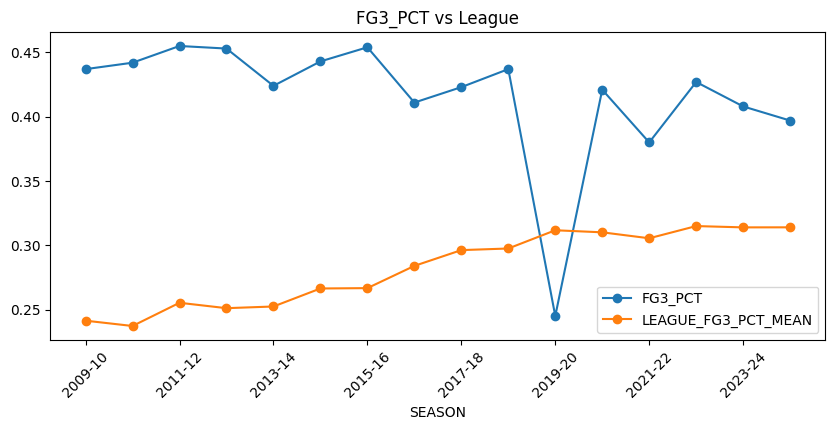

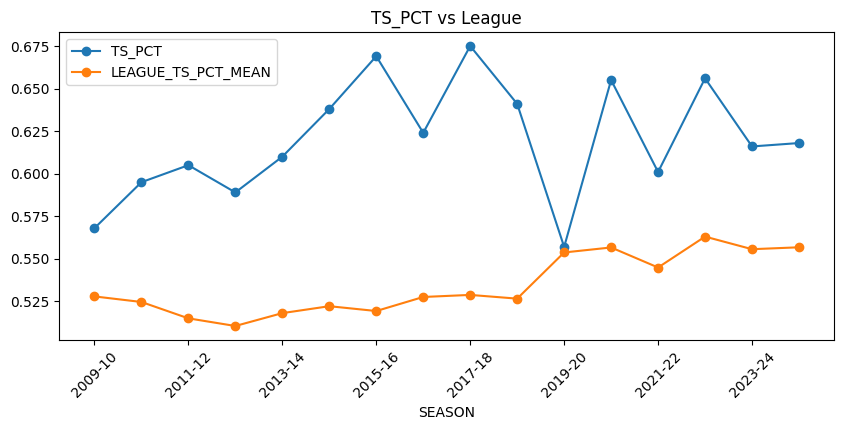

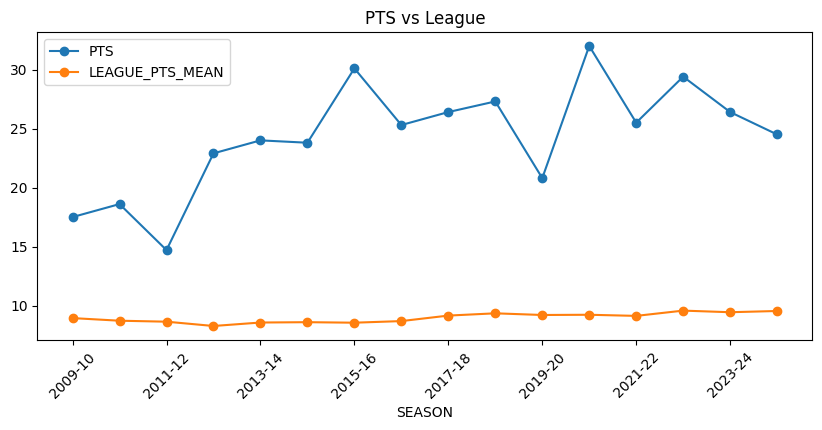

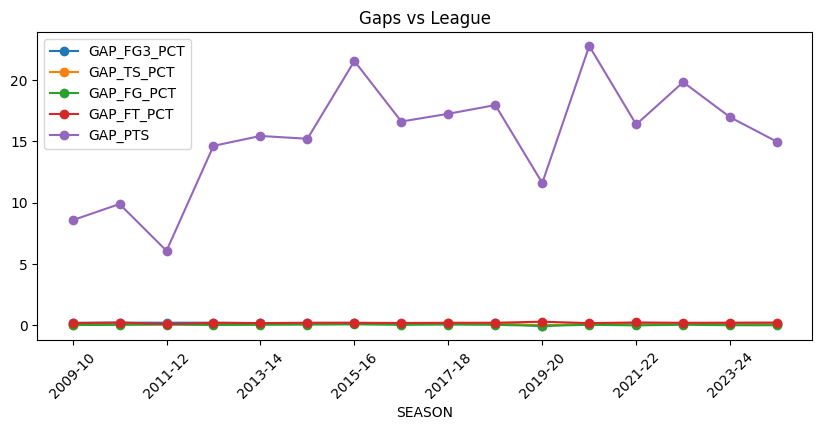

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir(r"C:\Users\stude\Documents\StephCurryProject")

df = pd.read_csv("data/processed/curry_vs_league_by_season.csv")

# Basic peek
display(df.head())
print(df.SEASON.min(), "→", df.SEASON.max())
print(df.columns.tolist())

# Line plots: Curry vs League
for metric, league in [("FG3_PCT","LEAGUE_FG3_PCT_MEAN"),
                       ("TS_PCT","LEAGUE_TS_PCT_MEAN"),
                       ("PTS","LEAGUE_PTS_MEAN")]:
    ax = df.plot(x="SEASON", y=[metric, league], marker="o", figsize=(10,4), rot=45)
    ax.set_title(f"{metric} vs League")
    plt.show()

# Gap plots (Curry - League)
gap_cols = [c for c in df.columns if c.startswith("GAP_")]
ax = df.plot(x="SEASON", y=gap_cols, marker="o", figsize=(10,4), rot=45)
ax.set_title("Gaps vs League")
plt.show()


Slope (gap per year): -0.00040781031880411764
Projected crossover age: None


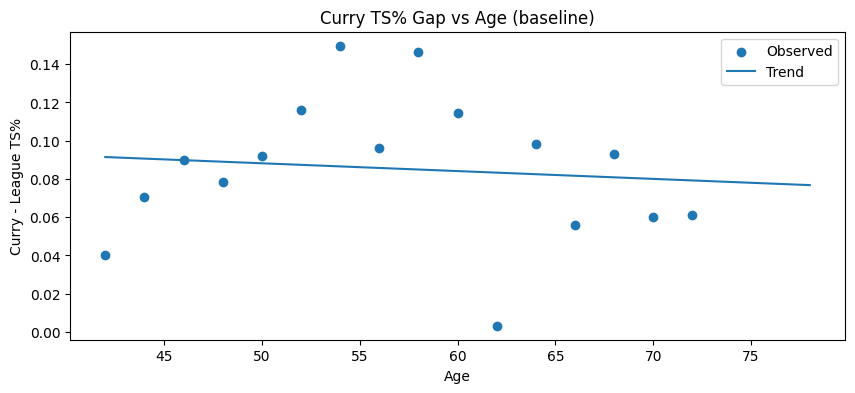

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

# rough age by season start (Curry born 1988; 2009–10 season -> ~21)
df["year_start"] = df["SEASON"].str.slice(0,4).astype(int)
df["age"] = df["year_start"] - 1988 + 21 - (2009 - df["year_start"])  # quick proxy if needed
# simpler: map ages manually if you prefer; or use exact birthdate + season start month

use = df.dropna(subset=["GAP_TS_PCT"]).copy()
X = use[["age"]].values
y = use["GAP_TS_PCT"].values

model = LinearRegression().fit(X, y)
ages_future = np.arange(int(use["age"].max())+1, int(use["age"].max())+7).reshape(-1,1)
pred_gap = model.predict(ages_future)

# Find first age where predicted gap < 0 (below league average)
crossover_age = None
for a, g in zip(ages_future.flatten(), pred_gap):
    if g < 0:
        crossover_age = int(a); break

print("Slope (gap per year):", model.coef_[0])
print("Projected crossover age:", crossover_age)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.scatter(use["age"], use["GAP_TS_PCT"], label="Observed")
age_line = np.arange(use["age"].min(), ages_future.max()+1).reshape(-1,1)
plt.plot(age_line, model.predict(age_line), label="Trend")
if crossover_age:
    plt.axvline(crossover_age, linestyle="--", label=f"Crossover ~ age {crossover_age}")
plt.title("Curry TS% Gap vs Age (baseline)")
plt.xlabel("Age"); plt.ylabel("Curry - League TS%")
plt.legend(); plt.show()


C:\Users\stude\Documents\StephCurryProject\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


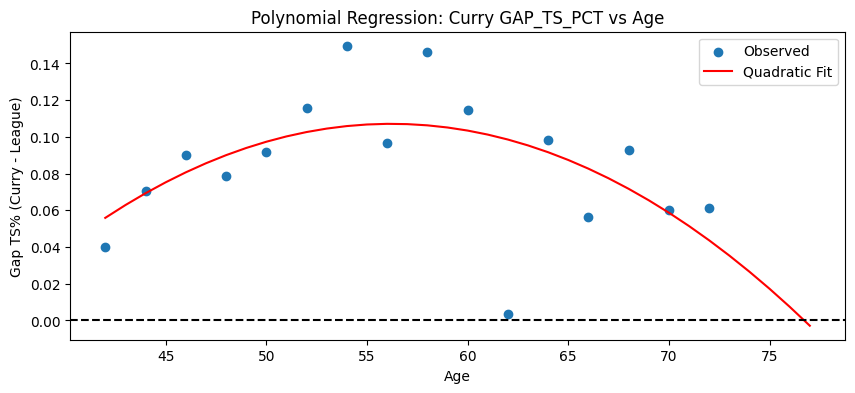

In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Build polynomial features (degree=2 → quadratic curve)
poly = PolynomialFeatures(2, include_bias=False)
Xp = poly.fit_transform(use[["age"]])  # turns [age] into [age, age^2]

m2 = LinearRegression().fit(Xp, y)

# Predict across a range of ages
import numpy as np
age_range = np.arange(use["age"].min(), use["age"].max()+6).reshape(-1,1)
Xp_range = poly.transform(age_range)
y_pred_poly = m2.predict(Xp_range)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.scatter(use["age"], y, label="Observed")
plt.plot(age_range, y_pred_poly, color="red", label="Quadratic Fit")
plt.axhline(0, color="black", linestyle="--")
plt.title("Polynomial Regression: Curry GAP_TS_PCT vs Age")
plt.xlabel("Age")
plt.ylabel("Gap TS% (Curry - League)")
plt.legend()
plt.show()


In [21]:
keep = ["SEASON","PTS","FG3_PCT","TS_PCT",
        "LEAGUE_PTS_MEAN","LEAGUE_FG3_PCT_MEAN","LEAGUE_TS_PCT_MEAN",
        "GAP_FG3_PCT","GAP_TS_PCT"]

df[keep].to_csv("data/processed/curry_model_input.csv", index=False)
print("Saved clean file: data/processed/curry_model_input.csv")

Saved clean file: data/processed/curry_model_input.csv
